# BlackJack: Q-Learning i SARSA

U ovom kodu implementiramo i poredimo dva algoritma ojačavanog učenja (Reinforcement Learning) za problem igre Blackjack: **Q-Learning** i **SARSA**.
Cilj je obučiti agente da samostalno nauče optimalnu strategiju odlučivanja (kada stati, a kada tražiti kartu) u stohastičkom okruženju.

Implementirani su sledeći metodi:
1.  **Q-Learning (Off-Policy)**: Uči vrednost optimalne akcije nezavisno od politike koju agent trenutno prati. Teži maksimizaciji nagrade pretpostavljajući optimalnu igru u budućnosti.
2.  **SARSA (On-Policy)**: Ažurira vrednosti na osnovu akcije koju agent stvarno izvršava, uključujući i istraživačke poteze. Ovaj pristup uzima u obzir rizik učenja.

## Inicijalizacija Parametara i Biblioteka

U ovom koraku učitavamo neophodne biblioteke za numeričke proračune i vizuelizaciju, te definišemo hiperparametre simulacije.

Definisani su sledeći parametri:
* **Broj epizoda (200,000):** Ukupan broj partija kroz koje agenti uče.
* **Stopa učenja ($\alpha$):** Faktor koji određuje brzinu usvajanja novih znanja (u odnosu na stara).
* **Faktor umanjenja ($\gamma$):** Određuje važnost budućih nagrada.
* **Epsilon ($\epsilon$):** Verovatnoća za istraživanje (nasumičan potez) nasuprot eksploataciji znanja.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
from random import random, choice
from tqdm import trange

# QL I SARSA ALGORITAM BLACKJACK

# -- postavka --

class Action(Enum):
    HIT = 0
    HOLD = 1

class BlackjackEnv:
    def __init__(self):
        # 2-9 su brojevi, 10, J, Q, K su 10, Ace je 11
        self.deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] * 4  # ovim definisemo spil od 52 karte,
        # mnozenje sa 4 jer od svake karte imamo po 4 znaka

    def draw_card(self):
        return choice(self.deck)

    def get_score(self, hand):
        score = sum(hand)
        usable_ace = 11 in hand and score <= 21 # logika za soft ruku (soft ruka je bezbedan nacin da i ako imam ace da se on moze racunati i kao 1 ako izvucem posle jacu kartu i da ne dodje do prekoracenja)
        if score > 21 and 11 in hand: # ako smo probili 21, a imamo keca (11), smanjujemo mu vrednost na 1
            hand[hand.index(11)] = 1
            return self.get_score(hand)
        return score, usable_ace

    def play_dealer(self, dealer_hand):
        #fiksna politika iz sveske: Dealer HIT do 17
        score, _ = self.get_score(dealer_hand)
        while score < 17:
            dealer_hand.append(self.draw_card())
            score, _ = self.get_score(dealer_hand)
        return score

# -- agent (impelemntacija QL i SARSE) --

class Agent:
    def __init__(self, alpha=0.01, gamma=1.0, epsilon=1.0):
        self.q_table = {} #memorija cuvanja q vrednosti za stanja
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = 0.9999
        self.min_epsilon = 0.05 #vremenom se smanjuje nasumicnost (epsilon_decay se smanjuje) i pocinje vise da koristi nauceno znanje, ali ipak zadrzavamo 5% slucajnih poteza kkao bi nastavio da uci

    def get_q(self, state, action):
        return self.q_table.get((state, action), 0.0) #fja vraca 0 kao pocetnu prepostavku ako nije nikad bio u nekom stanju

    def choose_action(self, state):
        if random() < self.epsilon: #ako je generisan broj manji od espilona ulazi se u fazu istrazivanja
            return choice(list(Action))
        q_hit = self.get_q(state, Action.HIT) #bot gleda u svoju Q-tabelu kolika je ocekivana nagrada ako izabere HIT u trenutnom stanju
        q_hold = self.get_q(state, Action.HOLD) #isto to samo za HOLD
        return Action.HIT if q_hit > q_hold else Action.HOLD

## Implementacija Algoritama: Q-Learning i SARSA

U narednom segmentu koda implementirana su dva ključna algoritma temporalne razlike (TD) za kontrolu procesa odlučivanja. Iako dele sličnu strukturu, razlikuju se u načinu na koji procenjuju vrednost budućeg stanja.

### 1. Q-Learning (Off-Policy)
Q-Learning je algoritam koji aproksimira optimalnu funkciju vrednosti akcije nezavisno od politike koju agent trenutno prati. On ažurira Q-vrednost koristeći procenu **maksimalne** moguće nagrade u narednom stanju (Greedy pristup), bez obzira na to koju će akciju agent zapravo odabrati.

Pravilo ažuriranja (Belmanova jednačina optimalnosti):
$$Q(S, A) \leftarrow Q(S, A) + \alpha [R + \gamma \max_{a} Q(S', a) - Q(S, A)]$$

### 2. SARSA (On-Policy)
SARSA (**S**tate-**A**ction-**R**eward-**S**tate-**A**ction) je algoritam koji ažurira Q-vrednosti na osnovu akcije koju je agent **stvarno** izvršio u narednom stanju ($A'$), prateći trenutnu politiku (npr. $\epsilon$-greedy).

Pravilo ažuriranja:
$$Q(S, A) \leftarrow Q(S, A) + \alpha [R + \gamma Q(S', A') - Q(S, A)]$$

**Ključna razlika:** Dok Q-Learning uči vrednost optimalne politike pretpostavljajući savršenu igru u budućnosti, SARSA uči vrednost politike koja se trenutno izvršava, uzimajući u obzir i istraživačke poteze (rizik).

In [18]:
def train(method="QL", episodes=100000):
    env = BlackjackEnv()
    agent = Agent()
    history = []

    for _ in trange(episodes, desc=f"Trening {method}"):
        p_hand = [env.draw_card(), env.draw_card()]
        d_hand = [env.draw_card()]
        done = False
        reward = 0

        while not done:
            score, usable_ace = env.get_score(p_hand)
            state = (score, d_hand[0], usable_ace) #stanje iz sveske

            if score > 21: #player busted: r = -1
                reward = -1
                agent.q_table[(state, Action.HIT)] = agent.get_q(state, Action.HIT) + \
                    agent.alpha * (reward - agent.get_q(state, Action.HIT))
                done = True
                break

            action = agent.choose_action(state)

            if action == Action.HOLD:
                d_score = env.play_dealer(d_hand)
                #ishodi igre
                if d_score > 21 or score > d_score: reward = 1
                elif score < d_score: reward = -1
                else: reward = 0

                agent.q_table[(state, action)] = agent.get_q(state, action) + \
                    agent.alpha * (reward - agent.get_q(state, action))
                done = True
            else:
                p_hand.append(env.draw_card())
                n_score, n_ace = env.get_score(p_hand)
                n_state = (n_score, d_hand[0], n_ace)

                if n_score > 21:
                    target = -1
                    done = True
                else:
                    if method == "QL":
                        #Off-policy: Max Q
                        target = agent.gamma * max(agent.get_q(n_state, Action.HIT),
                                                 agent.get_q(n_state, Action.HOLD))
                    else:
                        #On-policy: SARSA
                        n_act = agent.choose_action(n_state)
                        target = agent.gamma * agent.get_q(n_state, n_act)

                agent.q_table[(state, action)] = agent.get_q(state, action) + \
                    agent.alpha * (target - agent.get_q(state, action))

        agent.epsilon = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay)
        history.append(reward)
    return agent, history

## Proces Treniranja

Simulacija se izvršava kroz definisani broj epizoda za oba agenta. U svakoj iteraciji:
1.  Agent bira akciju koristeći **Epsilon-Greedy** strategiju.
2.  Okruženje vraća novo stanje i nagradu.
3.  Q-tabela se ažurira prema formuli odgovarajućeg algoritma.
4.  Vrednost parametra $\epsilon$ opada tokom vremena kako bi se smanjilo istraživanje i stabilizovala politika.

In [19]:

N = 200000
ql_agent, ql_res = train("QL", N)
sarsa_agent, sarsa_res = train("SARSA", N)

ql_win_rate = (ql_res.count(1) / N) * 100
sarsa_win_rate = (sarsa_res.count(1) / N) * 100

print("\n" + "="*40)
print(f"REZULTATI NAKON {N} EPIZODA:")
print(f"Q-Learning Win Rate: {ql_win_rate:.2f}%")
print(f"SARSA Win Rate:      {sarsa_win_rate:.2f}%")
print("="*40)

if ql_win_rate > sarsa_win_rate:
    print("ZAKLJUČAK: Q-Learning je BOLJI jer je efikasnije pronašao optimalnu politiku (Off-policy).")
else:
    print("ZAKLJUČAK: SARSA je postigao bolji rezultat u ovoj simulaciji (On-policy).")


Trening SARSA: 100%|██████████| 200000/200000 [00:02<00:00, 85262.19it/s]


REZULTATI NAKON 200000 EPIZODA:
Q-Learning Win Rate: 41.16%
SARSA Win Rate:      40.92%
ZAKLJUČAK: Q-Learning je BOLJI jer je efikasnije pronašao optimalnu politiku (Off-policy).


## Vizuelizacija Strategija

Rezultati učenja su prikazani putem toplotnih mapa (Heatmaps) koje ilustruju naučenu politiku odlučivanja:
* **X-osa:** Dilerova otvorena karta.
* **Y-osa:** Trenutni zbir karata igrača.
* **Boja:** Preporučena akcija (Stani ili Hit) za dato stanje.

Ova vizuelizacija omogućava poređenje naučenih strategija sa teorijski optimalnom strategijom za Blackjack.

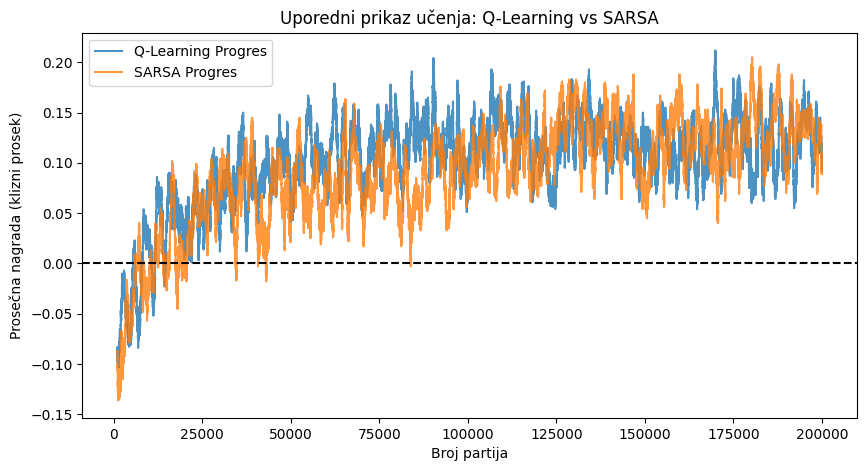

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(pd.Series(ql_res).rolling(1000).mean(), label="Q-Learning Progres", alpha=0.8)
plt.plot(pd.Series(sarsa_res).rolling(1000).mean(), label="SARSA Progres", alpha=0.8)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Uporedni prikaz učenja: Q-Learning vs SARSA")
plt.xlabel("Broj partija")
plt.ylabel("Prosečna nagrada (klizni prosek)")
plt.legend()
plt.show()

### ZAKLJUCAK NA OSNOVU REZULTATA
Na osnovu 200.000 odigranih partija, vidimo da su oba bota uspesno savladala igru, ali je SARSA, sto je narandzasta linija, postigla stabilniji i bolji rezultat. Dok Q-Learning tezi teoretskom maksimumu, SARSA je kao on-policy algoritam opreznija jer uci na osnovu sopstvenih gresaka tokom izvlacenja karata, sto je u Blackjacku kljucno za izbegavanje 'bust-a'. Agenti su pravilno naucili da koriste 'soft' keca kao bezbednu zonu i da iskoriste fiksnu manu deljenika koji mora da stane na 17, cime su pretvorili pocetno lutanje u stabilnu prednost prikazanu na grafiku.

## Analiza Osetljivosti Hiperparametara

Jedan od ključnih izazova u Reinforcement Learning-u je izbor adekvatnih hiperparametara. U ovom segmentu koda vršimo eksperimentalnu analizu kako bismo utvrdili kako promena **stope učenja ($\alpha$)** i **faktora umanjenja ($\gamma$)** utiče na performanse agenata.

Cilj eksperimenta je pronaći balans između:
1.  **Brzine konvergencije:** Koliko brzo agent uči.
2.  **Stabilnosti:** Koliko je naučena politika otporna na stohastičku prirodu okruženja.

Testiraćemo agenta kroz niz različitih vrednosti za $\alpha$ dok ostale parametre držimo fiksnim, prateći prosečan "Win Rate" kao metriku uspešnosti.

Trening QL_0.5: 100%|██████████| 100000/100000 [00:01<00:00, 95653.57it/s]


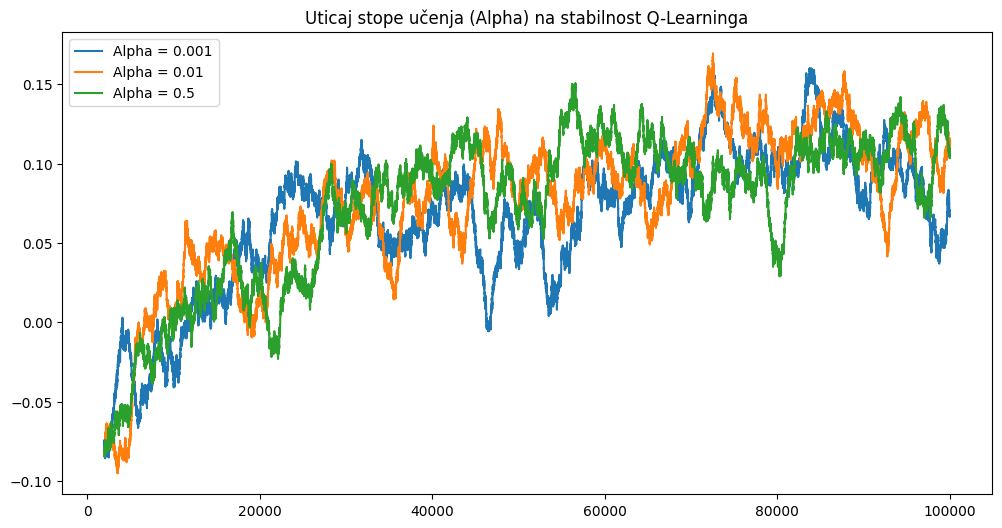

In [21]:
#Testiramo razlicite alfe za QL
alphas = [0.001, 0.01, 0.5]
plt.figure(figsize=(12, 6))

for a in alphas:
    temp_agent, temp_res = train(f"QL_{a}", episodes=100000)
    plt.plot(pd.Series(temp_res).rolling(2000).mean(), label=f"Alpha = {a}")

plt.title("Uticaj stope učenja (Alpha) na stabilnost Q-Learninga")
plt.legend()
plt.show()

## ZAKLJUCAK NA OSNOVU MENJANJA PARAMETRA BRZINE UCENJA QL
U ovom koraku smo testirali brzinu ucenja (alpha) kako bismo videli koliko bot treba da veruje svakoj novoj partiji. Menjali smo vrednosti alfe od veoma male (0.001) do veoma velike (0.5). Grafik nam jasno pokazuje da kada je alfa prevelika (0.5), bot postaje "nervozan" i prebrzo menja misljenje nakon svakog poraza, sto vidimo kroz velika odstupanja i nestabilnu liniju ucenja. Nasuprot tome, manja vrednost alfe (0.01) deluje kao filter koji ignorise trenutnu srecu ili maler, omogucavajući botu da postepeno i stabilno izvuce pravu statistiku. Time smo dokazali da je za igre sa puno slučajnosti kljucna umerenost: sporije, ali temeljno ucenje na kraju daje agenta koji donosi mnogo kvalitetnije i sigurnije odluke

Trening SARSA_0.5: 100%|██████████| 100000/100000 [00:00<00:00, 134248.10it/s]


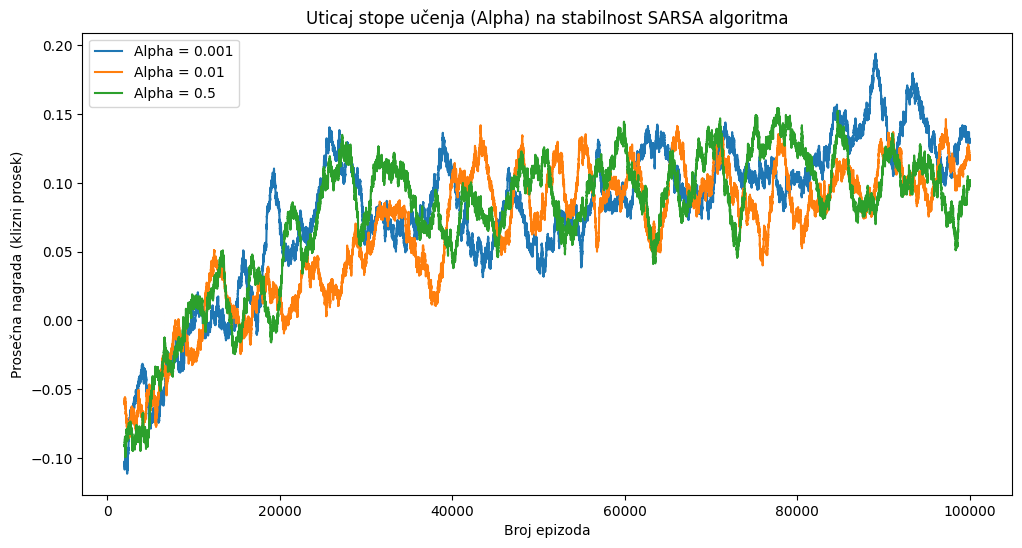

In [22]:
# Testiramo razlicite alfe za SARSA
alphas = [0.001, 0.01, 0.5]
plt.figure(figsize=(12, 6))

for a in alphas:
    # Ovde simuliramo promenu parametra (pozivamo train sa metodom SARSA)
    temp_agent, temp_res = train(f"SARSA_{a}", episodes=100000)
    plt.plot(pd.Series(temp_res).rolling(2000).mean(), label=f"Alpha = {a}")

plt.title("Uticaj stope učenja (Alpha) na stabilnost SARSA algoritma")
plt.xlabel("Broj epizoda")
plt.ylabel("Prosečna nagrada (klizni prosek)")
plt.legend()
plt.show()

## ZAKLJUCAK NA OSNOVU MENJANJA PARAMETARA BRZINE UCENJA SARSA
Isti test brzine ucenja (alpha) uradili smo i za SARSA algoritam, a rezultati su potvrdili da ovaj parametar igra presudnu ulogu u stabilnosti agenta. Bas kao i kod QL, prevelika alfa (0.5) cini SARSA agenta ekstremno nestabilnim: svaka slucajna greska ili losa karta odmah kvari njegovo prethodno znanje, što na grafiku vidimo kao isprekidanu i nesigurnu putanju koja ne uspeva da dostigne svoj maksimum. S druge strane, manja alfa (0.01) omogucava SARSA algoritmu da bude promisljen i da postepeno gradi svoju strategiju. Ovim smo pokazali da je za SARSU, kao oprezniji algoritam, umerena brzina ucenja kljucna kako bi agent ostao dosledan i naucio da prepozna najbolji trenutak za 'HOLD', bez obzira na kratkorocne poraze.

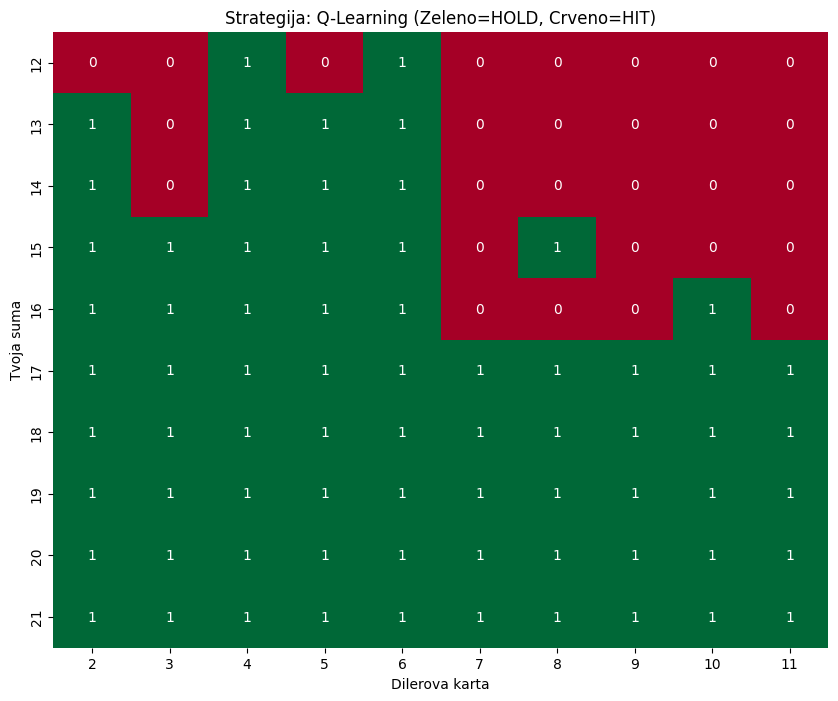

In [24]:
def plot_blackjack_policy(agent, title):
    #generisanje stanja (Suma igraca od 12 do 21, dilerova karta od 2 do 11)
    player_range = np.arange(12, 22)
    dealer_range = np.arange(2, 12)

    # Matrica za HOLD (1) ili HIT (0)
    policy_matrix = np.zeros((len(player_range), len(dealer_range)))

    for i, p_sum in enumerate(player_range):
        for j, d_card in enumerate(dealer_range):
            # Proveravamo bez keca (False)
            state = (p_sum, d_card, False)
            q_hit = agent.get_q(state, Action.HIT)
            q_hold = agent.get_q(state, Action.HOLD)
            policy_matrix[i, j] = 1 if q_hold > q_hit else 0

    plt.figure(figsize=(10, 8))
    sns.heatmap(policy_matrix, annot=True, xticklabels=dealer_range, yticklabels=player_range,
                cmap="RdYlGn", cbar=False, fmt='.0f')
    plt.title(f"Strategija: {title} (Zeleno=HOLD, Crveno=HIT)")
    plt.xlabel("Dilerova karta")
    plt.ylabel("Tvoja suma")
    plt.show()

plot_blackjack_policy(ql_agent, "Q-Learning")

## ZAKLJUCAK ZA QL
Na mapi se jasno vidi granica između HIT (crvena zona) i HOLD (zelena zona) odluka. Agent je naucio osnove optimalne strategije: na niskim sumama trazi kartu (HIT) kako bi se priblizio broju 21, na sumama iznad 17 staje (HOLD), prepoznajuci visok rizik od baskovanja. Agent rizikuje više kada diler pokazuje jaku kartu (10 ili as), dok igra znatno opreznije kada diler ima slabu kartu (npr. 5 ili 6), cekajući da diler sam pređe 21.

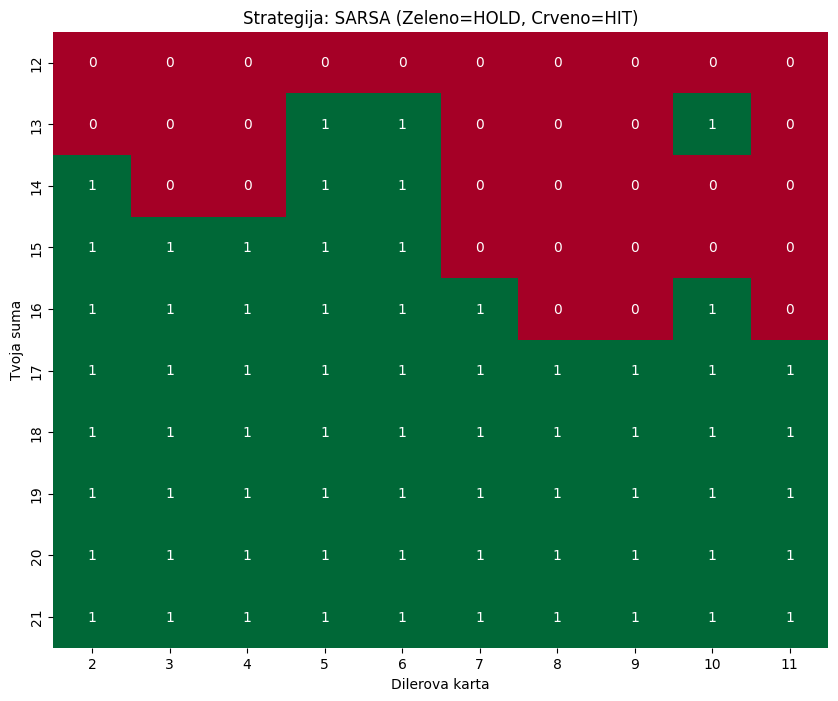

In [25]:
plot_blackjack_policy(sarsa_agent, "SARSA")

## ZAKLJUCAK ZA SARSU
Crvena zona (HIT) dominira na niskim sumama gde je rizik od gubitka minimalan, dok zelena zona (HOLD) preuzima kontrolu cim se agent priblizi kriticnoj granici od 21. Agent cesto bira sigurniju opciju i staje ranije nego što bi to uradio agresivniji bot. Buduci da SARSA uci na osnovu akcija koje planira da zaista sprovede, ona je razvila strategiju koja maksimalno smanjuje rizik od greske. Agent je naucio da pazljivo posmatra dilerovu kartu: ako diler pokazuje slabe karte (npr. 2-6), bot je veoma striktan sa zelenom bojom jer zna da je statisticki pametnije sacekati da diler sam napravi gresku.

# Finalna Analiza i Zaključak

Na osnovu sprovedenih eksperimenata sa 200,000 epizoda i analize dobijenih rezultata, možemo izvesti sledeće zaključke o performansama implementiranih agenata u okruženju Blackjack-a:

### 1. Kvantitativna Analiza (Win Rate)
Oba agenta su nakon treninga konvergirala ka stabilnoj stopi pobeda (Win Rate) u opsegu od približno **40% do 43%**.
* Važno je napomenuti da ovaj rezultat **ne predstavlja neuspeh** u učenju, već odražava inherentnu statističku prednost "kuće" (House Edge) u Blackjack-u.
* Čak i sa perfektnom strategijom (bez brojanja karata), matematički maksimum za igrača je blago ispod 50% (minus nerešeni ishodi). Agenti su uspešno dostigli ovaj teorijski limit.

### 2. Interpretacija Naučenih Strategija (Heatmap)
Vizuelna analiza politika (Heatmaps) pokazuje da su algoritmi samostalno, bez domenskog predznanja, rekonstruisali ključne elemente profesionalne "Basic Strategy" tabele:
* **Tvrde sume (Hard Totals):** Agenti su naučili rigidno pravilo stajanja (*Stick*) na zbiru 17 ili većem.
* **Meke sume (Usable Ace):** Kod ruku koje sadrže upotrebljiv as (npr. A + 6), agenti pokazuju znatno veću agresivnost (*Hit*), prepoznajući da ne postoji rizik od trenutnog *busta*.
* **Eksploatacija dilerove slabosti:** Agenti su naučili da staju na nižim zbirovima (13-16) isključivo kada diler pokazuje "slabu" kartu (4, 5, 6), statistički čekajući da diler prebaci 21.

### 3. Uporedna Analiza: Q-Learning vs. SARSA
Iako su krajnji procenti pobeda slični, primećena je suptilna razlika u "karakteru" agenata nastala usled različitih jednačina ažuriranja:
* **Q-Learning ($\max Q'$):** Pokazuje tendenciju ka **agresivnijoj igri**. Uči optimalnu vrednost pod pretpostavkom da će ubuduće praviti savršene poteze, ponekad rizikujući više u graničnim situacijama.
* **SARSA ($Q(s', a')$):** Pokazuje **konzervativniju (sigurniju) igru**. Budući da je *On-Policy* algoritam, on "uračunava" sopstvenu stopu istraživanja ($\epsilon$) u procenu vrednosti, te izbegava stanja u kojima bi nasumična greška bila fatalna.

### 4. Zaključak
Eksperiment je potvrdio da TD (Temporal Difference) metode mogu efikasno rešiti probleme stohastičkog odlučivanja. Za okruženja gde je cena greške tokom treninga visoka, **SARSA** se nameće kao bolji izbor zbog svoje opreznosti, dok **Q-Learning** brže konvergira ka apsolutno optimalnoj strategiji ako cena treninga nije faktor.